In [1]:
!pip install rdkit-pypi torch torch_geometric

In [2]:
import torch
from torch_geometric.data import Data, DataLoader
from rdkit import Chem
from rdkit.Chem import AllChem
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F


ModuleNotFoundError: No module named 'torch_geometric'

In [3]:
def smiles_to_graph(smiles):
    # Convert SMILES to RDKit molecule
    mol = Chem.MolFromSmiles(smiles)
    
    # Node features: atom type (atomic number)
    atoms = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    
    # Edge indices: bonds between atoms
    bonds = [(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in mol.GetBonds()]
    
    # Convert to PyTorch Geometric format
    edge_index = torch.tensor(bonds, dtype=torch.long).t().contiguous()
    x = torch.tensor(atoms, dtype=torch.float).view(-1, 1)  # Example node feature as atomic number
    
    return Data(x=x, edge_index=edge_index)


In [5]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r"C:\Users\Abhigna\OneDrive\Desktop\4-1 semester project\output.csv")  # replace with the actual path to your dataset

# Prepare the dataset for PyTorch Geometric
data_list = []
for idx, row in df.iterrows():
    smiles = row['smiles']
    ki_value = row['ki_value']
    
    # Convert SMILES to graph
    ligand_graph = smiles_to_graph(smiles)
    
    # Assign the binding affinity as the target variable
    ligand_graph.y = torch.tensor([ki_value], dtype=torch.float)
    
    # Append to list
    data_list.append(ligand_graph)


In [6]:
class GNNModel(torch.nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(1, 64)  # Input: node feature dimension (1) -> Hidden layer (64)
        self.conv2 = GCNConv(64, 128)  # Hidden layer (64) -> Hidden layer (128)
        self.fc1 = torch.nn.Linear(128, 1)  # Output layer for regression

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        # Global pooling to create a graph-level embedding
        x = global_mean_pool(x, data.batch)  
        return self.fc1(x)


In [8]:
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split

# Split data into train and test sets
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)

# Create PyTorch DataLoader for batching
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


C:\Users\Abhigna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [9]:
# Instantiate model, optimizer, and loss function
model = GNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs  # accumulate loss over batch size
    
    # Print the average training loss per epoch
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


C:\Users\Abhigna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Abhigna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50, Loss: 1.9399
Epoch 2/50, Loss: 0.8484
Epoch 3/50, Loss: 0.7922
Epoch 4/50, Loss: 0.7485
Epoch 5/50, Loss: 0.7286
Epoch 6/50, Loss: 0.7247
Epoch 7/50, Loss: 0.7223
Epoch 8/50, Loss: 0.7166
Epoch 9/50, Loss: 0.7192
Epoch 10/50, Loss: 0.7168
Epoch 11/50, Loss: 0.7190
Epoch 12/50, Loss: 0.7154
Epoch 13/50, Loss: 0.7156
Epoch 14/50, Loss: 0.7159
Epoch 15/50, Loss: 0.7135
Epoch 16/50, Loss: 0.7136
Epoch 17/50, Loss: 0.7135
Epoch 18/50, Loss: 0.7129
Epoch 19/50, Loss: 0.7134
Epoch 20/50, Loss: 0.7126
Epoch 21/50, Loss: 0.7121
Epoch 22/50, Loss: 0.7117
Epoch 23/50, Loss: 0.7110
Epoch 24/50, Loss: 0.7123
Epoch 25/50, Loss: 0.7103
Epoch 26/50, Loss: 0.7110
Epoch 27/50, Loss: 0.7109
Epoch 28/50, Loss: 0.7109
Epoch 29/50, Loss: 0.7100
Epoch 30/50, Loss: 0.7097
Epoch 31/50, Loss: 0.7090
Epoch 32/50, Loss: 0.7084
Epoch 33/50, Loss: 0.7086
Epoch 34/50, Loss: 0.7097
Epoch 35/50, Loss: 0.7086
Epoch 36/50, Loss: 0.7087
Epoch 37/50, Loss: 0.7085
Epoch 38/50, Loss: 0.7083
Epoch 39/50, Loss: 0.

In [10]:
model.eval()
test_loss = 0
with torch.no_grad():
    for data in test_loader:
        output = model(data)
        loss = loss_fn(output, data.y)
        test_loss += loss.item() * data.num_graphs  # accumulate loss over batch size

# Print the average test loss
avg_test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 0.7012


C:\Users\Abhigna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [11]:
torch.save(model.state_dict(), "gnn_model.pth")

In [12]:
import numpy as np

model.eval()
test_loss = 0
all_predictions = []
all_targets = []

with torch.no_grad():
    for data in test_loader:
        output = model(data)
        loss = loss_fn(output, data.y)
        test_loss += loss.item() * data.num_graphs  # accumulate loss over batch size
        
        # Collect predictions and targets for RMSE calculation
        all_predictions.extend(output.squeeze().tolist())
        all_targets.extend(data.y.squeeze().tolist())

# Calculate average test loss (Mean Squared Error)
avg_test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss (MSE): {avg_test_loss:.4f}")

# Calculate RMSE
rmse = np.sqrt(avg_test_loss)
print(f"Test RMSE: {rmse:.4f}")


Test Loss (MSE): 0.7012
Test RMSE: 0.8374


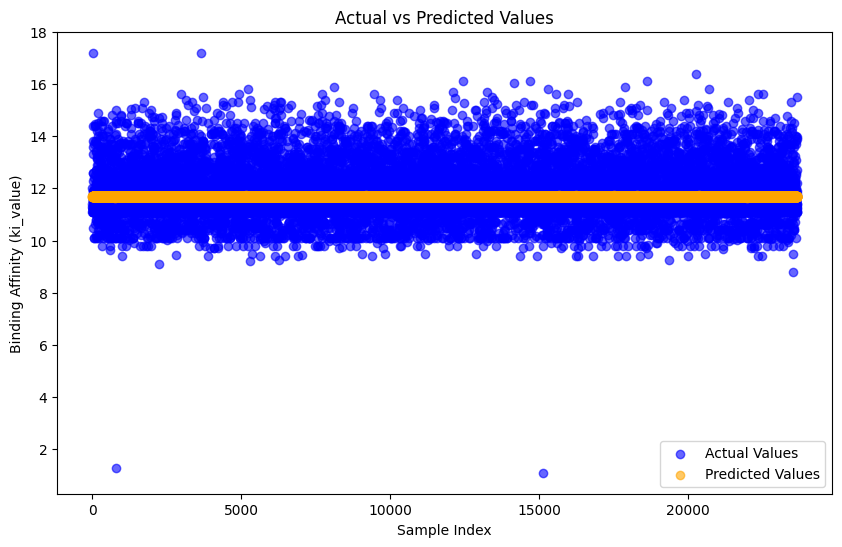

In [14]:
import matplotlib.pyplot as plt

# Convert all_predictions and all_targets to numpy arrays
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Create a range for the x-axis to plot the data points sequentially
x_range = np.arange(len(all_targets))

# Plotting actual and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(x_range, all_targets, color='b', alpha=0.6, label='Actual Values')
plt.scatter(x_range, all_predictions, color='orange', alpha=0.6, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Binding Affinity (ki_value)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


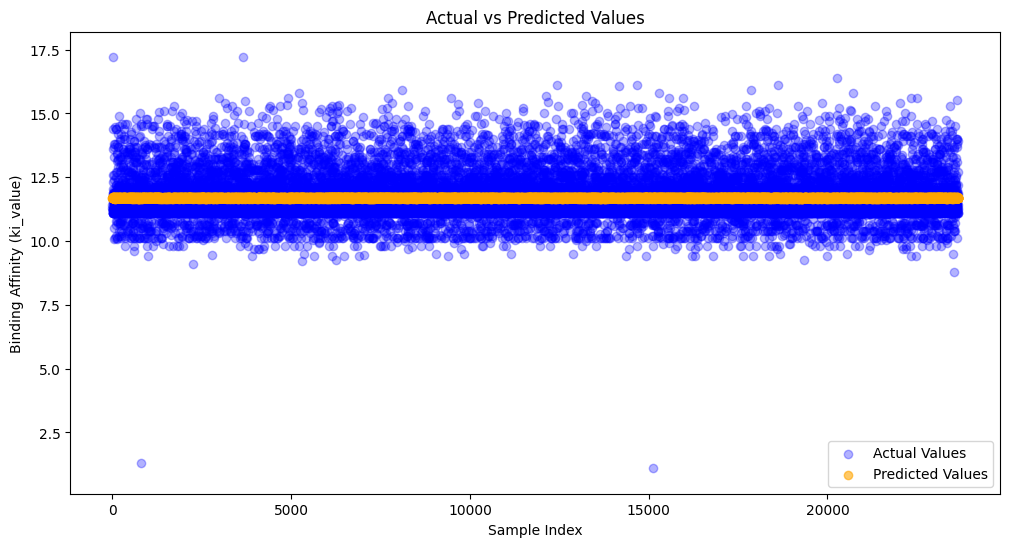

In [15]:
import matplotlib.pyplot as plt

# Plotting actual and predicted values with enhanced visualization
plt.figure(figsize=(12, 6))
plt.scatter(x_range, all_targets, color='b', alpha=0.3, label='Actual Values')
plt.scatter(x_range, all_predictions, color='orange', alpha=0.6, label='Predicted Values')
plt.plot(x_range, all_predictions, color='orange', linewidth=0.5)  # Add a line to show trend of predictions

# Zoom in on main range of values
plt.ylim(all_targets.min() - 1, all_targets.max() + 1)

plt.xlabel('Sample Index')
plt.ylabel('Binding Affinity (ki_value)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()
